#### Purpose of this notebook: collecting and testing in practice various algorithms used for clustering.
1. How to use them?
2. How to evaluate their quality?
3. What are some use-cases?
4. What needs to be kept in mind when using them?

## Import of libraries

In [52]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FixedLocator, FixedFormatter
import math
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, Birch, MeanShift, AffinityPropagation, SpectralClustering, DBSCAN, KMeans
import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import LogNorm

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Loading and preparing the dataset

In [2]:
df = pd.read_csv("apartments_for_clustering.csv")

In [3]:
df.drop(axis=1,columns=("Price category"),inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89264 entries, 0 to 89263
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   89264 non-null  int64  
 1   Bathrooms                    89264 non-null  float64
 2   Bedrooms                     89264 non-null  float64
 3   Fee                          89264 non-null  int64  
 4   Price                        89264 non-null  float64
 5   Square_feet                  89264 non-null  float64
 6   Latitude                     89264 non-null  float64
 7   Longitude                    89264 non-null  float64
 8   Population                   89264 non-null  float64
 9   Basketball                   89264 non-null  int64  
 10  Alarm                        89264 non-null  int64  
 11  Hot Tub                      89264 non-null  int64  
 12  Washer Dryer                 89264 non-null  int64  
 13  Cable or Satelli

In [5]:
# Taking 2 columns and sample of 1000 rows from df for a simple visualisation of the process
X = df[['Price','Square_feet']].sample(10000)

### K-means clustering

Advantages of K-Means:

Fast and computationally efficient, especially on large datasets.

Easy to understand and implement.

Works well with spherical, evenly sized clusters.

Scales well with the number of samples.

Disadvantages of K-Means:

Requires predefined number of clusters (k).

Sensitive to initial centroid placement; can converge to local minima.

Assumes clusters are convex and isotropic; struggles with irregular shapes.

Sensitive to outliers and noise.

Performs poorly with categorical or mixed-type data.

##### Implementation

In [6]:
#X,y = train_test_split(  df,test_size=0.2,random_state=42)
k = 2
k_means = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=k,random_state=42)
)
y_pred = k_means.fit_predict(X)
# Extract PCA and KMeans from the pipeline
scaler = k_means.named_steps['standardscaler']
kmeans = k_means.named_steps['kmeans']

# kmeans.labels_ - accessing the array of the predicted labels
# kmeans.cluster_centers_ - showing the centers of the found clusters

##### Plotting decision boundaries

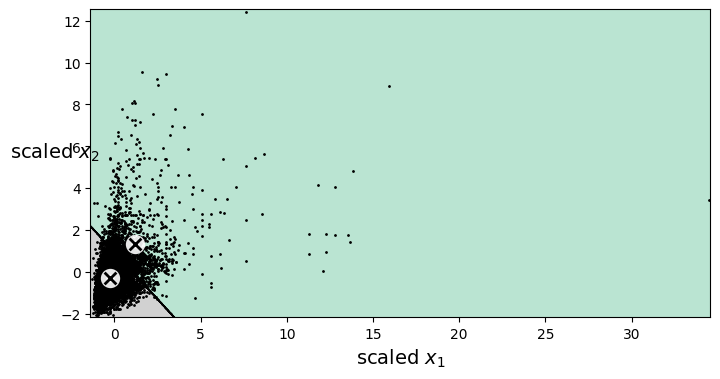

In [7]:
def plot_data(X):
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000,
                             show_centroids=True, show_xlabels=True, show_ylabels=True):
    # Get the scaler and the clustering model
    scaler = clusterer.named_steps['standardscaler']  # Use your actual step name
    kmeans = clusterer.named_steps['kmeans']          # Use your actual clustering step name

    # Transform the data
    X_scaled = pd.DataFrame(scaler.transform(X))

    # Create a grid in scaled space
    mins = X_scaled.min(axis=0) - 0.1
    maxs = X_scaled.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict cluster index for each point in the grid
    Z = kmeans.predict(grid).reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, Z, cmap="Pastel2", alpha=0.9)
    plt.contour(xx, yy, Z, linewidths=1, colors='k')

    # Plot scaled data
    plot_data(X_scaled)

    # Plot centroids in scaled space
    if show_centroids:
        plot_centroids(clusterer.named_steps['kmeans'].cluster_centers_)

    if show_xlabels:
        plt.xlabel("scaled $x_1$")
    else:
        plt.tick_params(labelbottom=False)

    if show_ylabels:
        plt.ylabel("scaled $x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(k_means, X)
plt.show()

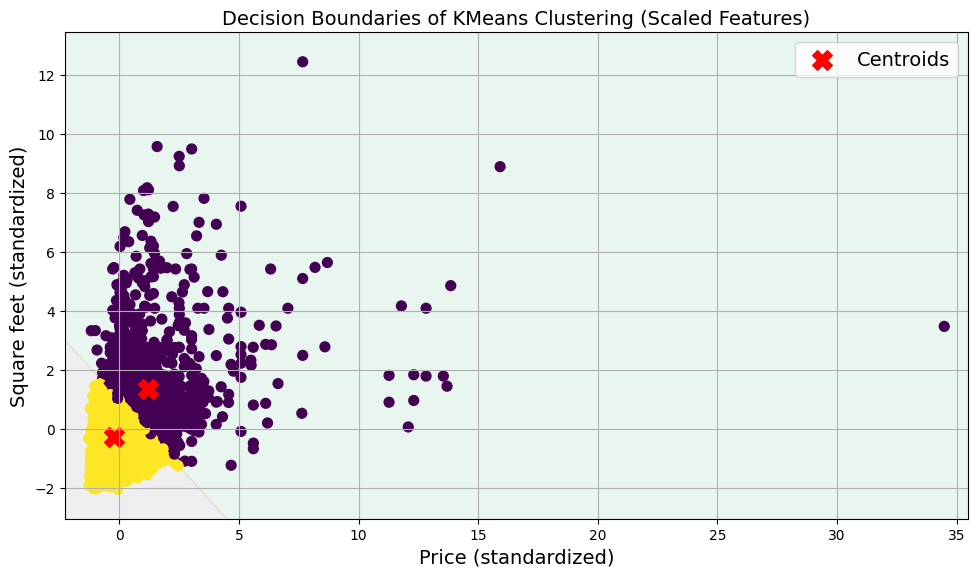

In [8]:
# Transform the data and keep feature names
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

# Create mesh grid in scaled space
x_min, x_max = X_scaled['Price'].min() - 1, X_scaled['Price'].max() + 1
y_min, y_max = X_scaled['Square_feet'].min() - 1, X_scaled['Square_feet'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict labels for mesh grid points
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries and data
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel2')

# Scatter original data (in scaled space)
plt.scatter(X_scaled['Price'], X_scaled['Square_feet'], 
            c=kmeans.labels_, cmap='viridis', s=50)

# Centroids (already in scaled space)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', marker='X', label='Centroids')

# Labels
plt.title("Decision Boundaries of KMeans Clustering (Scaled Features)")
plt.xlabel("Price (standardized)")
plt.ylabel("Square feet (standardized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




#### Searching for the optimal number of clusters

##### Checking inertia - elbow method (more general approach, lower computation cost)

In [9]:
k_values = range(2, 10)
inertias,silhouettes = [],[]

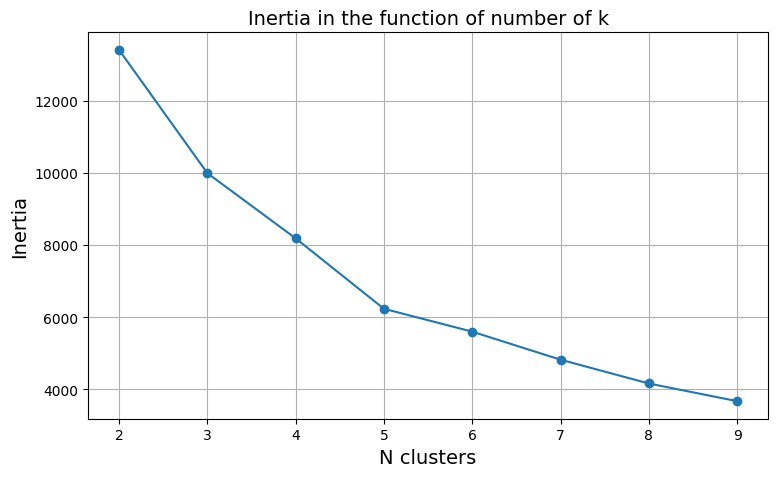

In [10]:
# Oblicz bezwładność dla każdej wartości k
for k in k_values:
    pipeline = make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k, random_state=42)
    )
    pipeline.fit(X)
    # Pobierz model KMeans z pipeline
    kmeans_model = pipeline.named_steps['kmeans']
    inertias.append(kmeans_model.inertia_)

# Narysuj wykres
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Inertia in the function of number of k')
plt.xlabel('N clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Checking silhouette score - the bigger the better (more precise and more computation heavy approach)

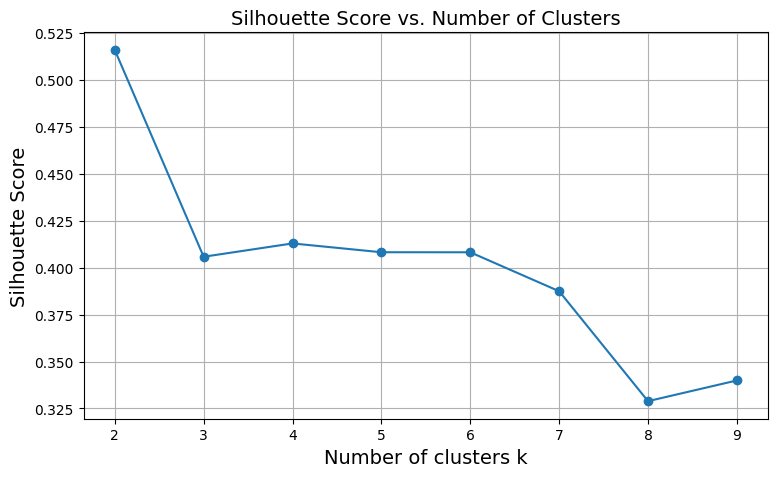

In [11]:
for k in k_values:
    if k < 2:
        continue  # Silhouette score requires at least 2 clusters
    
    pipeline = make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k, random_state=42)
    )
    pipeline.fit(X)
    
    # Get scaled data and KMeans model
    X_scaled = pipeline.named_steps['standardscaler'].transform(X)
    kmeans_model = pipeline.named_steps['kmeans']
    
    labels = kmeans_model.labels_
    if len(set(labels)) < 2:
        continue  # Skip silhouette score if only 1 cluster was formed
    
    score = silhouette_score(X_scaled, labels)
    silhouettes.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouettes, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Silhouette diagram

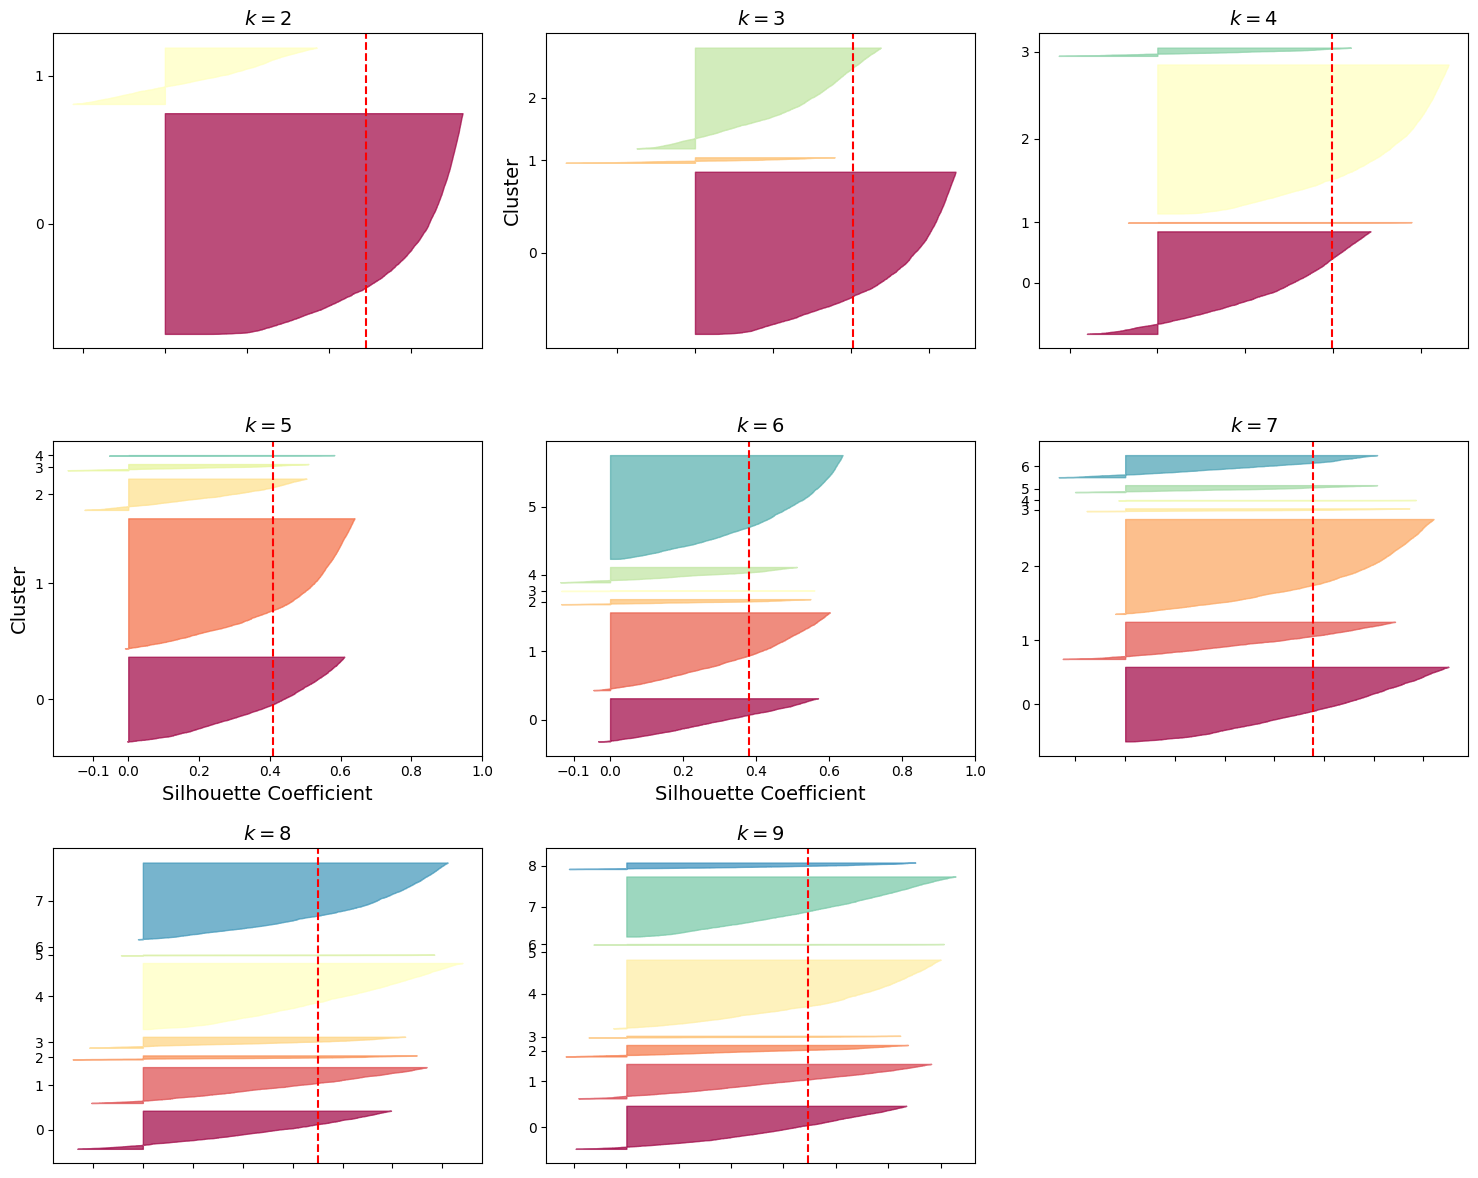

In [12]:
# Assume X is defined
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use k=2 to 9
#k_values = list(range(2, 10))

# Fit KMeans and compute silhouette scores
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled) for k in k_values]
silhouette_scores = [silhouette_score(X_scaled, model.labels_) for model in kmeans_per_k]

# Plotting
cols = 3
rows = math.ceil(len(k_values) / cols)
plt.figure(figsize=(5 * cols, 4 * rows))

for i, k in enumerate(k_values):
    plt.subplot(rows, cols, i + 1)
    kmeans = kmeans_per_k[i]
    y_pred = kmeans.labels_
    silhouette_coeffs = silhouette_samples(X_scaled, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []

    for cluster in range(k):
        coeffs = silhouette_coeffs[y_pred == cluster]
        coeffs.sort()
        color = plt.cm.Spectral(cluster / k)

        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if k in (3, 5):
        plt.ylabel("Cluster")
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[i], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.tight_layout()
plt.show()


##### Exercise 1: clustering in semi-supervised learning

##### Exercise 2: image segmentation

### DBSCAN - density-based spatial clustering of applications with noise

core concepts: epsilon, core instance

In [ ]:
dbscan = DBSCAN(eps = 1.3, min_samples= 5) #min_samples higher -> denser 
dbscan.fit(X)

,eps,1.3
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [14]:
dbscan.labels_ , dbscan.core_sample_indices_ , dbscan.components_ #-1 means that it is treated as an anomaly

(array([-1, -1, -1, ..., -1, -1, -1], shape=(10000,)),
 array([ 287,  314,  408,  409,  589,  831,  912, 2302, 2439, 2693, 3278,
        4189, 4312, 4428, 4500, 4859, 4974, 5063, 5064, 5430, 6369, 6847,
        7652, 8308, 8365, 9054, 9311]),
 array([[ 799.,  750.],
        [ 800.,  750.],
        [1200., 1200.],
        [1075., 1000.],
        [ 950.,  900.],
        [ 950.,  900.],
        [ 799.,  750.],
        [ 800.,  750.],
        [ 800.,  750.],
        [1200., 1200.],
        [ 700.,  600.],
        [ 700.,  600.],
        [ 699.,  600.],
        [1200., 1200.],
        [1075., 1000.],
        [ 800.,  750.],
        [ 700.,  600.],
        [1200., 1200.],
        [1075., 1000.],
        [1075., 1000.],
        [ 950.,  900.],
        [1075., 1000.],
        [ 950.,  900.],
        [1200., 1200.],
        [1200., 1200.],
        [ 950.,  900.],
        [ 700.,  600.]]))

Looking for the best epsilon parameter - DBSCAN is unsupervised, so it doesn't fit well into the cross_validate framework, which is designed for supervised estimators.
Silhouette score is not a built-in scoring string in scikit-learn, so you need to use make_scorer with a custom function.DBSCAN does not have a predict method, which cross_validate expects.

In [15]:
X_scaled = StandardScaler().fit_transform(X)
# Define a range of epsilon values to test
eps_values = np.arange(0.1, 1.5, 0.1)
best_eps = None
best_score = -1
# Perform cross-validation using silhouette score
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    # Only compute silhouette score if more than 1 cluster is found
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_eps = eps
print(f"Best epsilon: {best_eps}")
print(f"Best silhouette score: {best_score}")



Best epsilon: 1.3000000000000003
Best silhouette score: 0.8808996501574952


#### Why use or not use DBSCAN?
Pros:
+ able to identify any number of clusters of any shape
+ resistant to outliers
+ 2 hyperparameters

Againsts:
- if clusters differ significantly in density or there is no low-density area around some clusters, DBSCAN might not specify all clusters
- O(m^2*n) = low scalability

### Remaining clustering algorithms:
+ Aglomeracyjna analiza skupień – Agglomerative Clustering
+ BIRCH – Balanced Iterative Reducing and Clustering using Hierarchies
+ Mean-shift – Mean Shift Clustering
+ Propagacja prawdopodobieństwa – Affinity Propagation
+ Widmowa analiza skupień – Spectral Clustering

C:\Users\mijanisz\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


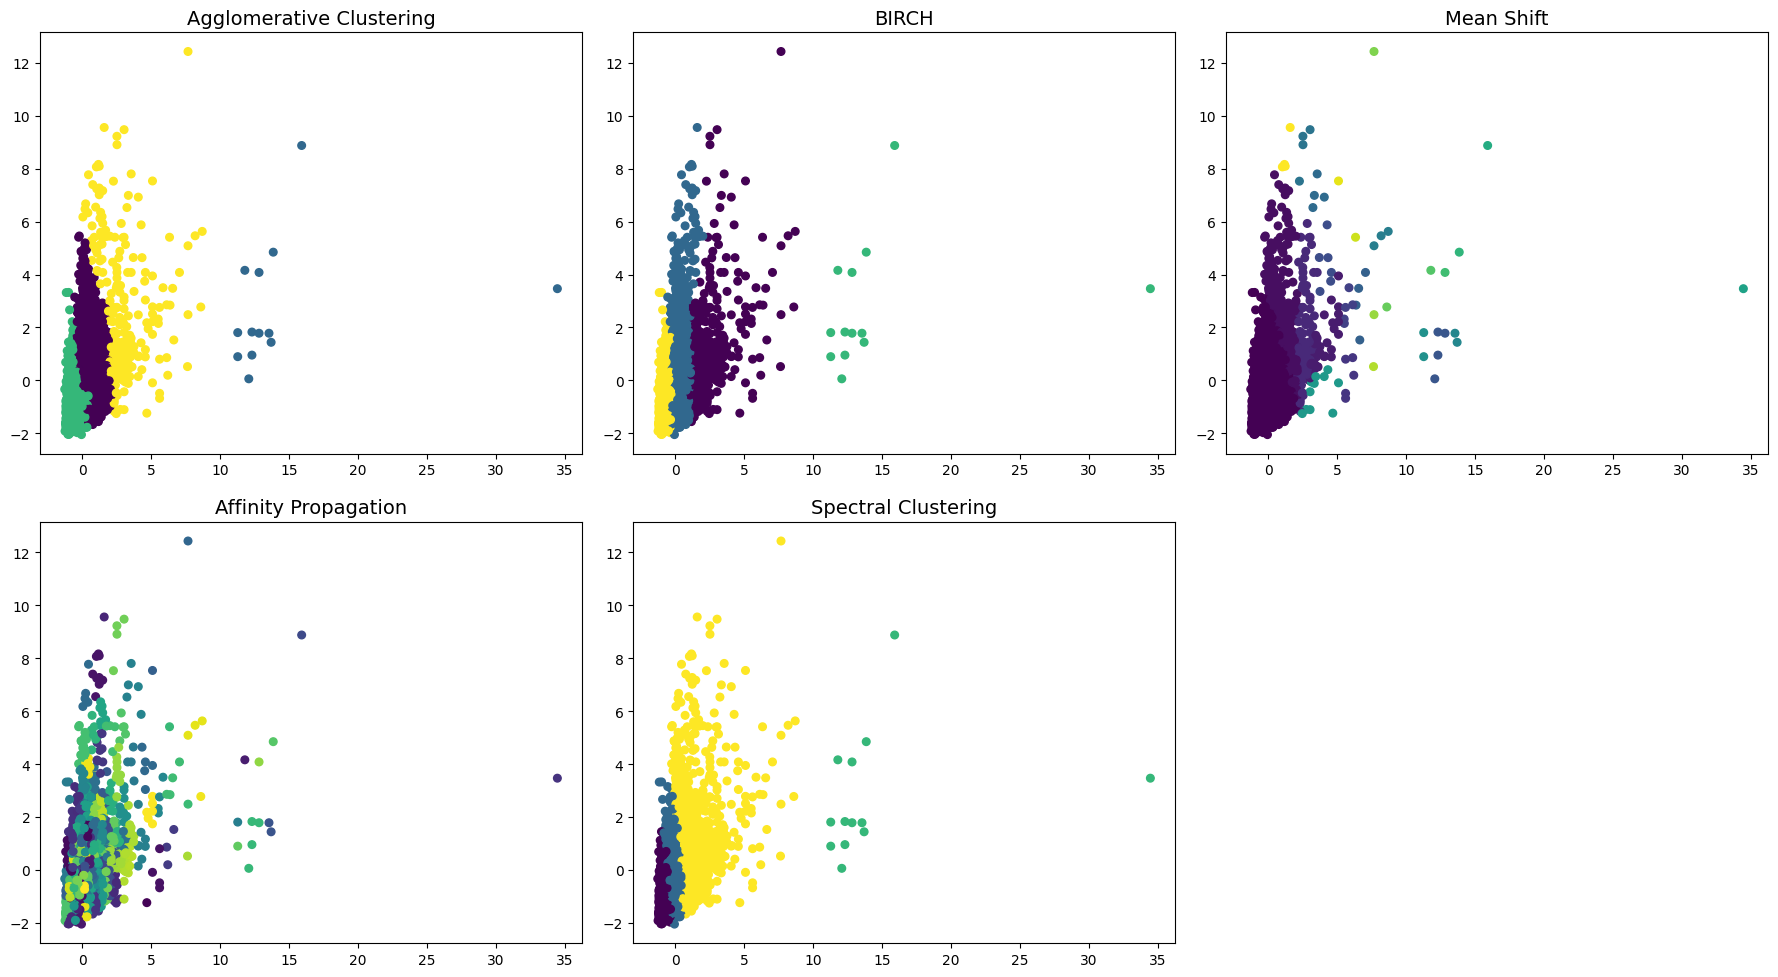

In [ ]:
# Generate synthetic dataset
#X, _ = make_blobs(n_samples=500, centers=4, cluster_std=1.0, random_state=42)

# Define clustering algorithms
clustering_algorithms = {
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=4),
    "BIRCH": Birch(n_clusters=4),
    "Mean Shift": MeanShift(),
    "Affinity Propagation": AffinityPropagation(damping=0.9, random_state=42),
    "Spectral Clustering": SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
}

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, algorithm) in enumerate(clustering_algorithms.items()):
    labels = algorithm.fit_predict(X)
    axes[i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=30)
    axes[i].set_title(name)

# Hide the last subplot if unused
if len(clustering_algorithms) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

### Gaussian Mixture Model (GMM, model mieszanin gaussowskich)
It might be used to density estimation, clustering and anomaly detection

🔹 Key Features:
You specify the number of components (n_components) manually.
Uses maximum likelihood estimation to fit the model.
Can overfit if the number of components is too high.

✅ Use when:
You know or can estimate the number of clusters.
You want a straightforward clustering or density estimation.

In [76]:
from sklearn.mixture import GaussianMixture
gm_model = make_pipeline(
    StandardScaler(),
    GaussianMixture(n_components=5,
                     n_init=10,
                     covariance_type='full') # covariance types: full, spherical, diag, tied
)
gm_model.fit(X)

,steps,"[('standardscaler', ...), ('gaussianmixture', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,5
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06


In [77]:
gm = gm_model.named_steps['gaussianmixture']

In [78]:
gm.weights_, gm.means_, gm.covariances_, gm.converged_, gm.n_iter_

(array([0.31097872, 0.43245846, 0.19448867, 0.00950926, 0.0525649 ]),
 array([[-0.13362448,  0.42277606],
        [-0.47193702, -0.53200744],
        [ 0.67018737, -0.1905251 ],
        [ 5.11612214,  4.25111989],
        [ 1.26801638,  1.81160319]]),
 array([[[ 0.15753185,  0.04671388],
         [ 0.04671388,  0.32046102]],
 
        [[ 0.11066152,  0.04107016],
         [ 0.04107016,  0.21828138]],
 
        [[ 0.44039239,  0.16961667],
         [ 0.16961667,  0.44612616]],
 
        [[23.40111507, -3.63461949],
         [-3.63461949,  7.41988419]],
 
        [[ 1.37603087, -0.64231126],
         [-0.64231126,  2.267949  ]]]),
 True,
 15)

In [79]:
new_dp = np.array([1500,25]).reshape(1, -1)
gm.predict(new_dp), gm.predict_proba(new_dp.round(3))

(array([3]), array([[0., 0., 0., 1., 0.]]))

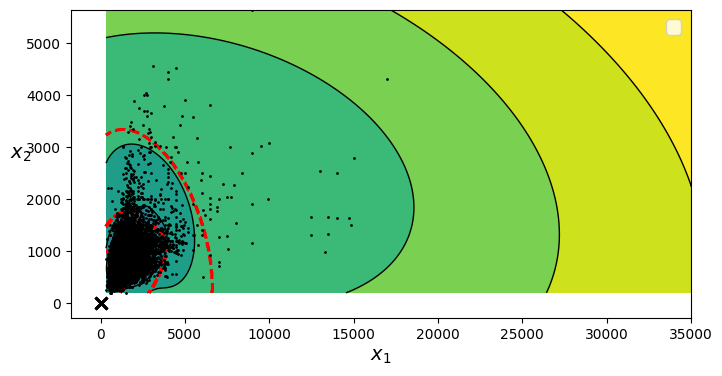

In [80]:

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2, label = 'Data points')
    gmm = clusterer.named_steps['gaussianmixture']
    plot_centroids(gmm.means_, gmm.weights_)


    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plt.legend()

plot_gaussian_mixture(gm_model, X)

#save_fig("gaussian_mixtures_plot")
plt.show()

Exercise: use GMM for anomaly detection

#### Searching for the best n of clusters

In [ ]:
gm.bic(X) , gm.aic(X)

# create a plote for each value k and its AIC score - the lower the better

# ...

(np.float64(3869132380.7716093), np.float64(3869132171.6717386))

### Bayesian Gaussian Mixture
🔹 Key Features:
Automatically determines the number of effective components.
Uses variational inference instead of maximum likelihood.
More robust to overfitting and can discard unnecessary components.

✅ Use when:
You’re unsure about the number of clusters.
You want a more flexible, probabilistic approach.

In [88]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10,n_init=10,random_state=42)
bgm.fit(X).weights_.round(2)
labels = bgm.predict(X)